## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [82]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [83]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist already exists!


In [84]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

In [85]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [86]:
print(len(fmnist_dataset_train))
len(fmnist_dataset_test)

60000


10000

In [87]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [88]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Linear(200, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [89]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 64]          12,864
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 171,042
Trainable params: 171,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.65
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


Your experiments come here:

In [90]:
def train_model(model, train_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []

        model.train(True)
        for X_batch, y_batch in train_loader:

            X_train, y_train = X_batch.to(device), y_batch.to(device)

            model.zero_grad()
            out = model(X_train)
            loss = loss_fn(out, y_train)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss += ep_train_loss

    return train_loss

In [91]:
model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()



train_loss = train_model(model, train_loader, loss_func, opt, n_epochs=10)



Epoch 1 of 10
Epoch 2 of 10
Epoch 3 of 10
Epoch 4 of 10
Epoch 5 of 10
Epoch 6 of 10
Epoch 7 of 10
Epoch 8 of 10
Epoch 9 of 10
Epoch 10 of 10


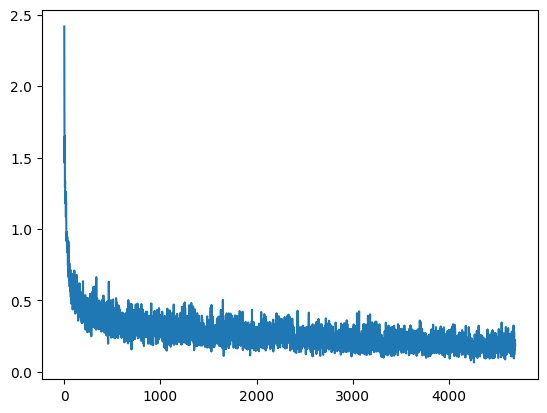

In [92]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.show()

In [93]:
def evaluate(model, loader):
    right_unsuers = 0
    number_of_unsuers = 0
    for X_test, y_test in loader:
        model.eval()
        with torch.no_grad():
            _, predicted = torch.max(model(X_test), 1)
            right_unsuers += (predicted == y_test).sum().item()
    return right_unsuers / len(loader.dataset)

In [94]:

print("Train accuracy is:", evaluate(model, train_loader))
print("Test accuracy is:", evaluate(model, test_loader))

Train accuracy is: 0.9348833333333333
Test accuracy is: 0.8861


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [147]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [148]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 32]           2,080
             ReLU-13                   [-1, 32]               0
           Linear-14                   

In [149]:
def train_model(model, train_loader, loss_func, opt, n_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            opt.zero_grad()
            out = model(X_batch)
            loss = loss_func(out, y_batch)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            _, predicted = torch.max(out, 1)
            correct += (predicted == y_batch).sum().item()

        avg_loss = total_loss / len(train_loader) #средняя ошибка, на определенном числе эпох
        accuracy = correct / len(train_loader.dataset) #accuracy тренировки, на определенном числе эпох
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_func(out, y_batch)

                total_test_loss += loss.item()
                _, predicted = torch.max(out, 1)
                correct_test += (predicted == y_batch).sum().item()

        avg_test_loss = total_test_loss / len(test_loader) #средняя ошибка, на определенном числе эпох
        test_accuracy = correct_test / len(test_loader.dataset) #accuracy теста, на определенном числе эпох
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1} of {n_epochs}')

    return train_losses, train_accuracies, test_losses, test_accuracies

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()


In [150]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, loss_func, opt, n_epochs=50)

Epoch 1 of 50
Epoch 2 of 50
Epoch 3 of 50
Epoch 4 of 50
Epoch 5 of 50
Epoch 6 of 50
Epoch 7 of 50
Epoch 8 of 50
Epoch 9 of 50
Epoch 10 of 50
Epoch 11 of 50
Epoch 12 of 50
Epoch 13 of 50
Epoch 14 of 50
Epoch 15 of 50
Epoch 16 of 50
Epoch 17 of 50
Epoch 18 of 50
Epoch 19 of 50
Epoch 20 of 50
Epoch 21 of 50
Epoch 22 of 50
Epoch 23 of 50
Epoch 24 of 50
Epoch 25 of 50
Epoch 26 of 50
Epoch 27 of 50
Epoch 28 of 50
Epoch 29 of 50
Epoch 30 of 50
Epoch 31 of 50
Epoch 32 of 50
Epoch 33 of 50
Epoch 34 of 50
Epoch 35 of 50
Epoch 36 of 50
Epoch 37 of 50
Epoch 38 of 50
Epoch 39 of 50
Epoch 40 of 50
Epoch 41 of 50
Epoch 42 of 50
Epoch 43 of 50
Epoch 44 of 50
Epoch 45 of 50
Epoch 46 of 50
Epoch 47 of 50
Epoch 48 of 50
Epoch 49 of 50
Epoch 50 of 50


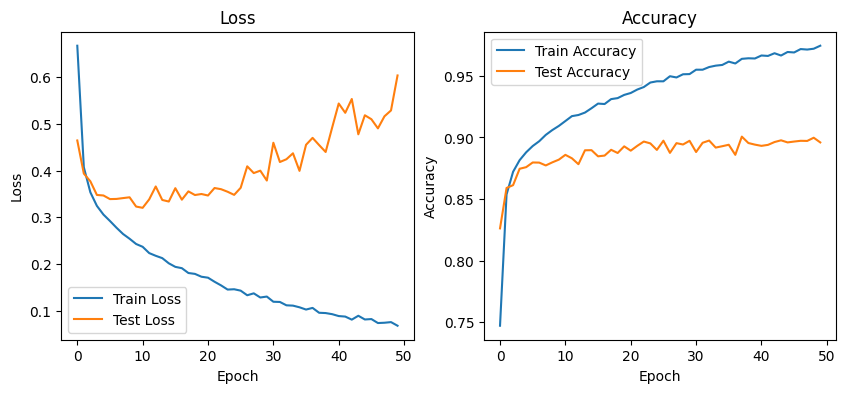

In [151]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Как видно на графике, ошибка теста начинает сильно расти, в то время как ошибка тренировки стремится к нулю, это переобучение.
Так что где-то 10 эпох будет достаточно

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [157]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [158]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Dropout-3                  [-1, 128]               0
       BatchNorm1d-4                  [-1, 128]             256
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
           Dropout-7                   [-1, 64]               0
       BatchNorm1d-8                   [-1, 64]             128
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated T

In [159]:
def train_model(model, train_loader, loss_func, opt, n_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            opt.zero_grad()
            out = model(X_batch)
            loss = loss_func(out, y_batch)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            _, predicted = torch.max(out, 1)
            correct += (predicted == y_batch).sum().item()

        avg_loss = total_loss / len(train_loader) #средняя ошибка, на определенном числе эпох
        accuracy = correct / len(train_loader.dataset) #accuracy тренировки, на определенном числе эпох
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_func(out, y_batch)

                total_test_loss += loss.item()
                _, predicted = torch.max(out, 1)
                correct_test += (predicted == y_batch).sum().item()

        avg_test_loss = total_test_loss / len(test_loader) #средняя ошибка, на определенном числе эпох
        test_accuracy = correct_test / len(test_loader.dataset) #accuracy теста, на определенном числе эпох
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1} of {n_epochs}')

    return train_losses, train_accuracies, test_losses, test_accuracies

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()


In [160]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, loss_func, opt, n_epochs=50)

Epoch 1 of 50
Epoch 2 of 50
Epoch 3 of 50
Epoch 4 of 50
Epoch 5 of 50
Epoch 6 of 50
Epoch 7 of 50
Epoch 8 of 50
Epoch 9 of 50
Epoch 10 of 50
Epoch 11 of 50
Epoch 12 of 50
Epoch 13 of 50
Epoch 14 of 50
Epoch 15 of 50
Epoch 16 of 50
Epoch 17 of 50
Epoch 18 of 50
Epoch 19 of 50
Epoch 20 of 50
Epoch 21 of 50
Epoch 22 of 50
Epoch 23 of 50
Epoch 24 of 50
Epoch 25 of 50
Epoch 26 of 50
Epoch 27 of 50
Epoch 28 of 50
Epoch 29 of 50
Epoch 30 of 50
Epoch 31 of 50
Epoch 32 of 50
Epoch 33 of 50
Epoch 34 of 50
Epoch 35 of 50
Epoch 36 of 50
Epoch 37 of 50
Epoch 38 of 50
Epoch 39 of 50
Epoch 40 of 50
Epoch 41 of 50
Epoch 42 of 50
Epoch 43 of 50
Epoch 44 of 50
Epoch 45 of 50
Epoch 46 of 50
Epoch 47 of 50
Epoch 48 of 50
Epoch 49 of 50
Epoch 50 of 50


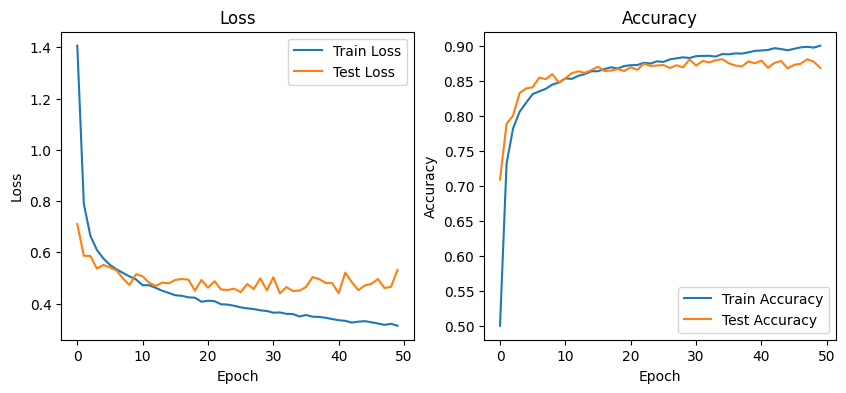

In [161]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

Я ждал 20 минут, и переобучения действительно не происходит, ВАУ.